In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
import dask
dask.config.set(scheduler='threads')

In [4]:
# Remote Zarr Data Linking (CHIRPS Complete)
store_url = "https://nyu1.osn.mghpcc.org/leap-pangeo-pipeline/chirps_feedstock/chirps-global-daily.zarr"
# Load Zarr Data
ds = xr.open_dataset(store_url, engine="zarr", consolidated=True)

# Automatically determine latitude order and crop Ghana region (4°N-11°N, -3°-2°E)
lat_min, lat_max = 4, 11
if ds.latitude[0] < ds.latitude[-1]:
    lat_slice = slice(lat_min, lat_max)
else:
    lat_slice = slice(lat_max, lat_min)

ghana_ds = ds.sel(
    latitude=lat_slice,
    longitude=slice(-3, 2),
    time=slice("2000-01-01", "2020-12-31")
)

# save as NetCDF file
ghana_ds.to_netcdf("/home/jovyan/Project_Ghana/ghana_chirps_2000_2020.nc")

ds = xr.open_dataset("/home/jovyan/Project_Ghana/ghana_chirps_2000_2020.nc")
precip = ds['precip']

print(precip)

precip = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6])).compute()

print(precip.shape) 

<xarray.DataArray 'precip' (time: 7671, latitude: 140, longitude: 100)> Size: 430MB
[107394000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 560B 4.025 4.075 4.125 ... 10.87 10.92 10.97
  * longitude  (longitude) float32 400B -2.975 -2.925 -2.875 ... 1.925 1.975
  * time       (time) datetime64[ns] 61kB 2000-01-01 2000-01-02 ... 2020-12-31
Attributes:
    geostatial_lat_max:  50.0
    geostatial_lat_min:  -50.0
    geostatial_lon_max:  180.0
    geostatial_lon_min:  -180.0
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    standard_name:       convective precipitation rate
    time_step:           day
    units:               mm/day
(2562, 140, 100)


In [2]:
# Figure 1 #

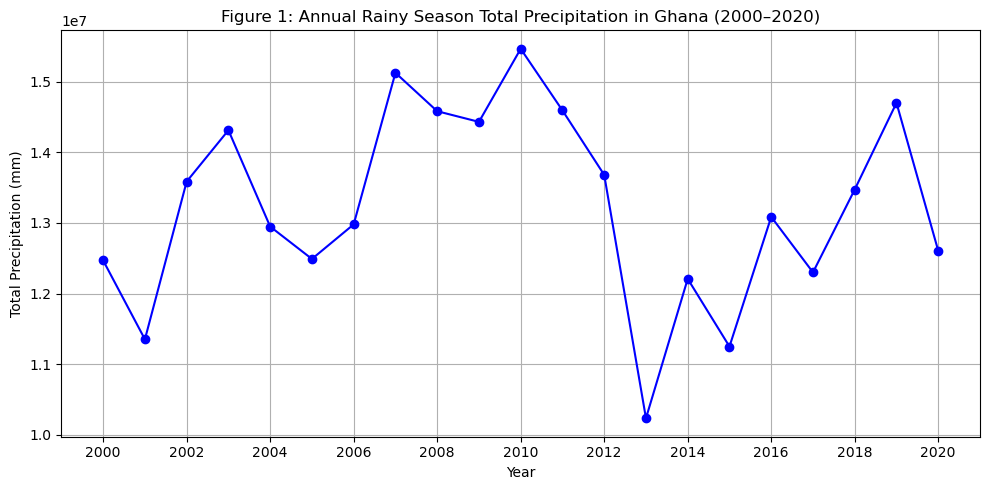

In [13]:
# Create list of years
years = np.arange(2000, 2021)

# Compute Annual Rainy Season Total Precipitation
annual_total = precip.groupby('time.year').sum(dim=['time', 'latitude', 'longitude'])

# Plot: Annual Rainy Season Total Precipitation in Ghana (2000 - 2020)
plt.figure(figsize=(10, 5))
plt.plot(years, annual_total.values, marker='o', linestyle='-', color='blue')
plt.title("Figure 1: Annual Rainy Season Total Precipitation in Ghana (2000–2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.xlabel("Year")
plt.ylabel("Total Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Figure 2 #

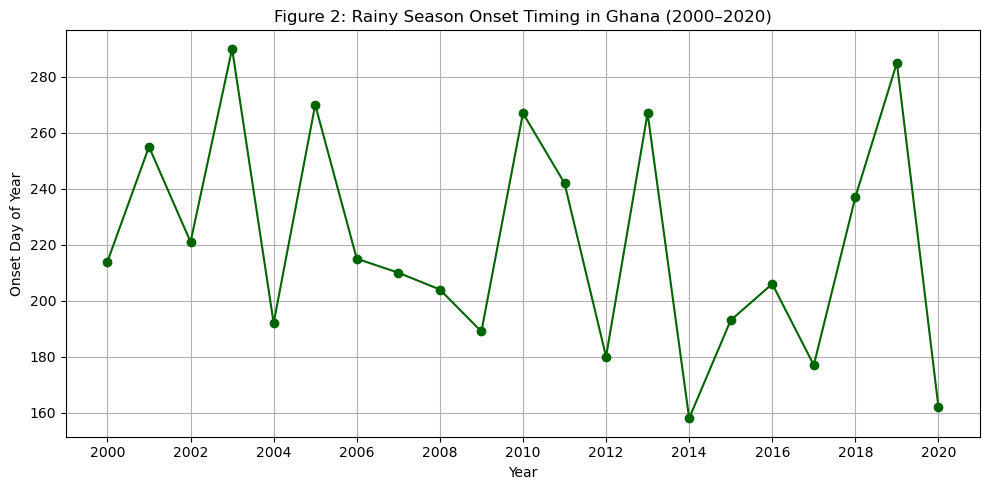

In [12]:
precip = ds['precip']

rolling = precip.rolling(time=5).mean()
onset_days = []
for year in years:
    season = rolling.sel(time=str(year))
    mean_over_space = season.mean(dim=['latitude', 'longitude'])
    onset_day = mean_over_space.where(mean_over_space > 1).argmax(dim='time')
    onset_days.append(ds.time.sel(time=str(year))[onset_day].dt.dayofyear.values)

# Plot Figure 2: Rainy Season Onset Timing (Day of Year)
plt.figure(figsize=(10, 5))
plt.plot(years, onset_days, marker='o', linestyle='-', color='darkgreen')
plt.title("Figure 2: Rainy Season Onset Timing in Ghana (2000–2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.xlabel("Year")
plt.ylabel("Onset Day of Year")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Figure 3 #

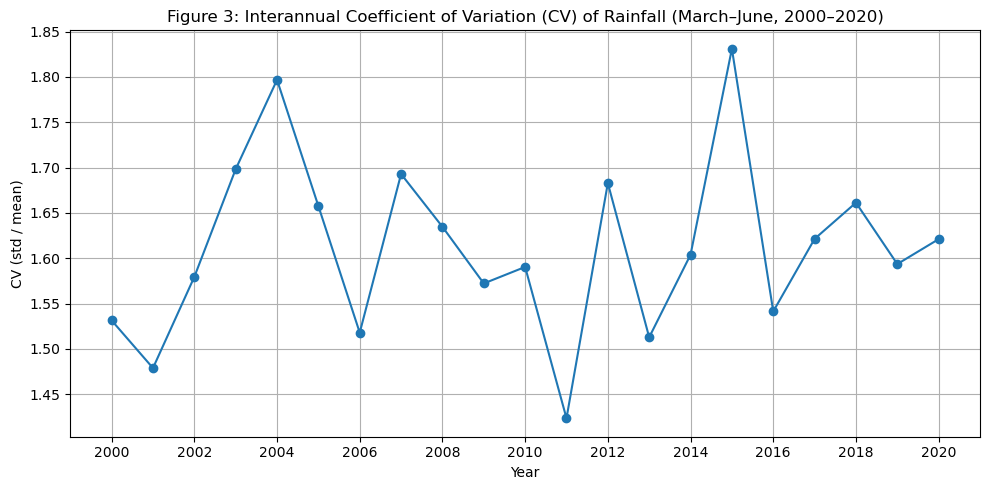

In [11]:
precip = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

# Group by year and compute mean and std over time and space
season_mean = precip.groupby('time.year').mean(dim=['time', 'latitude', 'longitude'])
season_std = precip.groupby('time.year').std(dim=['time', 'latitude', 'longitude'])

# Calculate Coefficient of Variation (CV)
cv = season_std / season_mean

# Plot CV time series
plt.figure(figsize=(10, 5))
cv.plot(marker='o')
plt.title("Figure 3: Interannual Coefficient of Variation (CV) of Rainfall (March–June, 2000–2020)")
plt.xticks(np.arange(2000, 2021, 2))
plt.xlabel("Year")
plt.ylabel("CV (std / mean)")
plt.grid(True)
plt.tight_layout()
plt.show()